<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


<h1>Softmax Classifier</h1>


<h2>Objective</h2><ul><li> How to classify handwritten digits from the MNIST database by using Softmax classifier.</li></ul> 


<h2>Table of Contents</h2>
<p>In this lab, you will use a single layer Softmax to classify handwritten digits from the MNIST database.</p>

<ul>
    <li><a href="#Makeup_Data">Make some Data</a></li>
    <li><a href="#Classifier">Softmax Classifier</a></li>
    <li><a href="#Model">Define Softmax, Criterion Function, Optimizer, and Train the Model</a></li>
    <li><a href="#Result">Analyze Results</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>

<hr>


<h2>Preparation</h2>


We'll need the following libraries


In [1]:
# Import the libraries we need for this lab

# Using the following line code to install the torchvision library
# !conda install -y torchvision

!pip install torchvision==0.9.1 torch==1.8.1 
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

     |████████████████████████████████| 17.4 MB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 804.1 MB 563 bytes/s  0:00:0112               | 2.6 MB 56.6 MB/s eta 0:00:15     |▏                               | 4.0 MB 56.6 MB/s eta 0:00:15 |▏                               | 4.6 MB 56.6 MB/s eta 0:00:15.0 MB 123.9 MB/s eta 0:00:07  | 29.8 MB 123.9 MB/s eta 0:00:07█▍                              | 34.0 MB 123.9 MB/s eta 0:00:07     |█▍                              | 34.8 MB 123.9 MB/s eta 0:00:07                          | 36.1 MB 123.9 MB/s eta 0:00:07                          | 58.1 MB 4.4 MB/s eta 0:02:51                          | 60.5 MB 4.4 MB/s eta 0:02:51▍                             | 61.2 MB 4.4 MB/s eta 0:02:514 MB/s eta 0:02:50     |██▌                             | 62.8 MB 4.4 MB/s eta 0:02:50                          | 63.4 MB 256 kB/s eta 0:48:06     |███▍                            | 85.7 MB 256 kB/s eta 0:46:39     |███▍                            | 86.5 MB

Use the following function to plot out the parameters of the Softmax function:


In [2]:
# The function to plot parameters

def PlotParameters(model): 
    W = model.state_dict()['linear.weight'].data
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    for i, ax in enumerate(axes.flat):
        if i < 10:
            
            # Set the label for the sub-plot.
            ax.set_xlabel("class: {0}".format(i))

            # Plot the image.
            ax.imshow(W[i, :].view(28, 28), vmin=w_min, vmax=w_max, cmap='seismic')

            ax.set_xticks([])
            ax.set_yticks([])

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
    plt.show()

Use the following function to visualize the data: 


In [3]:
# Plot the data

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))

<!--Empty Space for separating topics-->


<h2 id="Makeup_Data">Make Some Data</h2> 


Load the training dataset by setting the parameters <code>train</code> to <code>True</code> and convert it to a tensor by placing a transform object in the argument <code>transform</code>.


In [4]:
# Create and print the training dataset

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
print("Print the training dataset:\n ", train_dataset)

Print the training dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


Load the testing dataset and convert it to a tensor by placing a transform object in the argument <code>transform</code>.


In [5]:
# Create and print the validating dataset

validation_dataset = dsets.MNIST(root='./data', download=True, transform=transforms.ToTensor())
print("Print the validating dataset:\n ", validation_dataset)

Print the validating dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


You can see that the data type is long:


In [6]:
# Print the type of the element

print("Type of data element: ", type(train_dataset[0][1]))

Type of data element:  <class 'int'>


Each element in the rectangular tensor corresponds to a number that represents a pixel intensity as demonstrated by the following image:


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter3/3.32_image_values.png" width="550" alt="MNIST elements" />


In this image, the values are inverted i.e back represents wight.


Print out the label of the fourth element:


In [7]:
# Print the label

print("The label: ", train_dataset[3][1])

The label:  1


The result shows the number in the image is 1


Plot  the fourth sample:


The image:  None


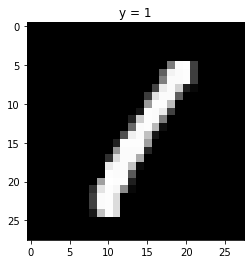

In [8]:
# Plot the image

print("The image: ", show_data(train_dataset[3]))

You see that it is a 1. Now, plot the third sample:


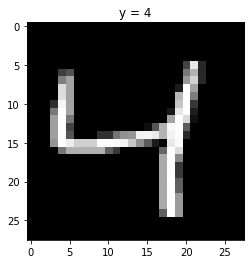

In [9]:
# Plot the image

show_data(train_dataset[2])

<!--Empty Space for separating topics-->


<h2 id="#Classifier">Build a Softmax Classifer</h2>


Build a Softmax classifier class: 


In [10]:
# Define softmax classifier class

class SoftMax(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        z = self.linear(x)
        return z

The Softmax function requires vector inputs. Note that the vector shape is 28x28.


In [11]:
# Print the shape of train dataset

train_dataset[0][0].shape

torch.Size([1, 28, 28])

Flatten the tensor as shown in this image: 


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter3/3.3.2image_to_vector.gif" width="550" alt="Flattern Image" />


The size of the tensor is now 784.


<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter3/3.3.2Imagetovector2.png" width="550" alt="Flattern Image" />


Set the input size and output size: 


In [12]:
# Set input size and output size

input_dim = 28 * 28
output_dim = 10

<!--Empty Space for separating topics-->


<h2 id="Model">Define the Softmax Classifier, Criterion Function, Optimizer, and Train the Model</h2> 


In [13]:
# Create the model

model = SoftMax(input_dim, output_dim)
print("Print the model:\n ", model)

Print the model:
  SoftMax(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


View the size of the model parameters: 


In [14]:
# Print the parameters

print('W: ',list(model.parameters())[0].size())
print('b: ',list(model.parameters())[1].size())

W:  torch.Size([10, 784])
b:  torch.Size([10])


You can cover the model parameters for each class to a rectangular grid:  


<a>     <img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter3/3.3.2paramaters_to_image.gif" width = 550, align = "center"></a> 


Plot the model parameters for each class as a square image: 


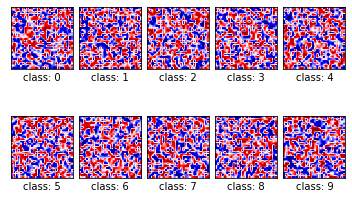

In [15]:
# Plot the model parameters for each class

PlotParameters(model)

Define the learning rate, optimizer, criterion, data loader:


In [16]:
# Define the learning rate, optimizer, criterion and data loader

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

Train the model and determine validation accuracy **(should take a few minutes)**: 


In [ ]:
# Train the model

n_epochs = 10
loss_list = []
accuracy_list = []
N_test = len(validation_dataset)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            
        correct = 0
        # perform a prediction on the validationdata  
        for x_test, y_test in validation_loader:
            z = model(x_test.view(-1, 28 * 28))
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)

train_model(n_epochs)

<!--Empty Space for separating topics-->


<h2 id="Result">Analyze Results</h2> 


Plot the loss and accuracy on the validation data:


In [ ]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

View the results of the parameters for each class after the training. You can see that they look like the corresponding numbers. 


In [ ]:
# Plot the parameters

PlotParameters(model)

We Plot the first five misclassified  samples and the probability of that class.


In [ ]:
# Plot the misclassified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 5:
        break       

<!--Empty Space for separating topics-->


We Plot the first five correctly classified samples and the probability of that class, we see the probability is much larger.


In [ ]:
# Plot the classified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat == y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 5:
        break  

<a href="https://dataplatform.cloud.ibm.com/registration/stepone?context=cpdaas&apps=data_science_experience,watson_machine_learning"><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/Watson_Studio.png"/></a>


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD. 


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description                                          |
| ----------------- | ------- | ---------- | ----------------------------------------------------------- |
| 2020-09-23        | 2.0     | Shubham    | Migrated Lab to Markdown and added to course repo in GitLab |


<hr>


## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
